# PREDICT SALES OF THE ROSSMAN STORES

This project aims to predict the sales of the Rossman Stores for next 6 weeks.

# 0 - IMPORTS

In [70]:
import datetime
import inflection
import math

import pandas                     as pd
import numpy                      as np
import seaborn                    as sns

from IPython.display              import Image

from matplotlib.gridspec          import GridSpec
from matplotlib                   import pyplot          as plt

from scipy                        import stats           as ss

## 0.1 - Helper functions

In [73]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.2 - Loading data

In [2]:
# dataset
df_sales = pd.read_csv('dataset/train.csv', low_memory=False)
df_stores = pd.read_csv('dataset/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales, df_stores, how='left', on='Store')

# 1 - DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1 - Rename columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'Id', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2 - Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1001599
Number of columns: 19


## 1.3 - Data types

In [6]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
id                                int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
id                                       int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
id                                   0
store_type                           0
assortment                           0
competition_distance              2600
competition_open_since_month    318392
competition_open_since_year     318392
promo2                               0
promo2_since_week               500415
promo2_since_year               500415
promo_interval                  500415
dtype: int64

## 1.5 - Fillout NA

In [9]:
# competition distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                                                                    x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                                                                  x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else 
                                                                              x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                                                              x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                       0, axis=1)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
id                              0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Change data types

In [11]:
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 - Descriptive statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical attributes

In [13]:
# Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.436424,558.0,321.909047,-0.000970,-1.200532
1,day_of_week,1.0,7.0,6.0,3.998315,4.0,1.997349,0.001618,-1.246824
2,sales,0.0,41551.0,41551.0,5770.573039,5741.0,3852.565888,0.643199,1.780100
3,customers,0.0,7388.0,7388.0,633.302988,610.0,464.942753,1.596438,7.073761
4,open,0.0,1.0,1.0,0.829645,1.0,0.375944,-1.753697,1.075454
5,promo,0.0,1.0,1.0,0.381894,0.0,0.485851,0.486181,-1.763631
6,school_holiday,0.0,1.0,1.0,0.173460,0.0,0.378644,1.724790,0.974903
7,id,0.0,1017207.0,1017207.0,508518.856749,508810.0,293464.542300,-0.000361,-1.199537
8,competition_distance,20.0,200000.0,199980.0,5935.551264,2330.0,12545.981696,10.241280,147.787195
9,competition_open_since_month,1.0,12.0,11.0,6.781137,7.0,3.319975,-0.039549,-1.241021


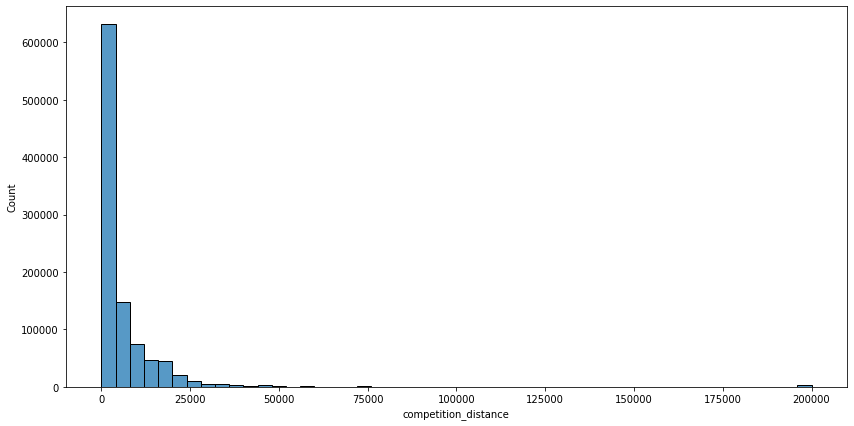

In [14]:
plt.figure(figsize=(14,7)) 
sns.histplot(df1['competition_distance'], kde=False, bins=50);

### 1.7.2 - Categorical attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

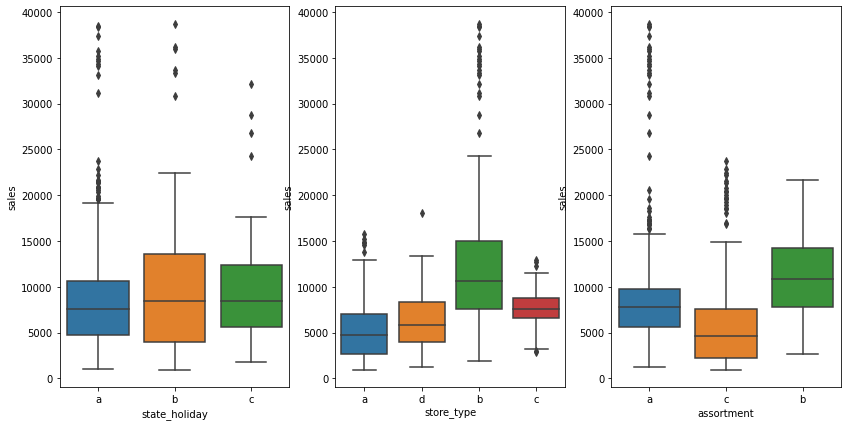

In [16]:
aux = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.figure(figsize=(14,7)) 
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1 - Mind map hypotheses

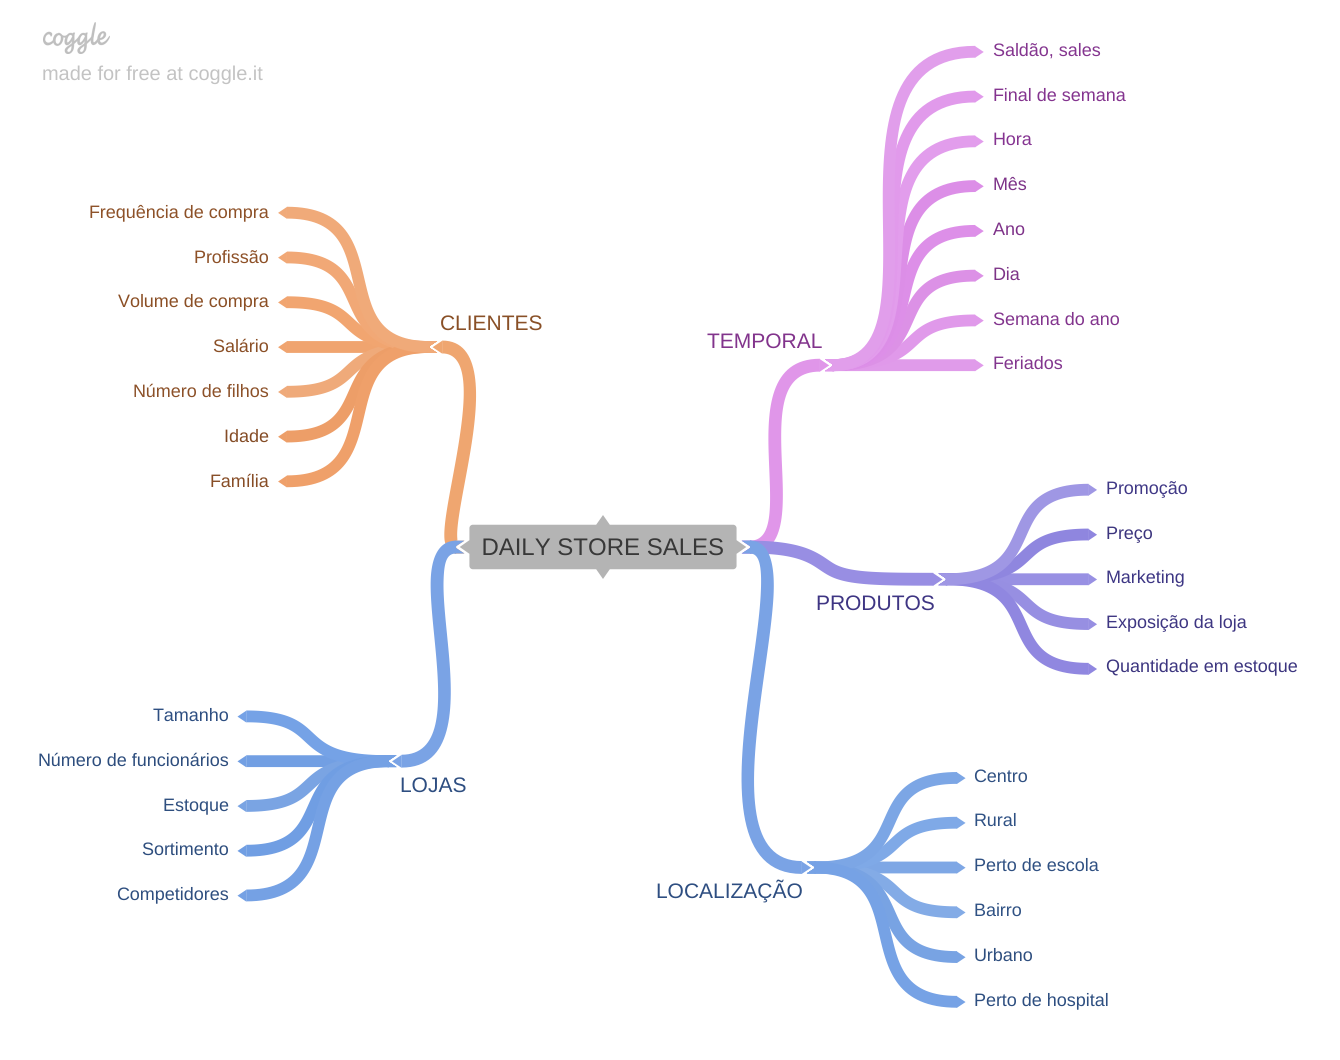

In [18]:
Image('img/DAILY_STORE_SALES.png')

## 2.2 - Creation of hypotheses

### 2.2.1 - Store hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with greater assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.2.2 - Product hypotheses

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with longer active promotions should sell more.

**7.** Stores with more days of promotion should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 - Time hypotheses

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 - Selected hypothses

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4 - Feature engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year']= df2['date'].dt.isocalendar().week

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# 3 - DATA FILTERING

In [20]:
df3 = df2.copy()

In [21]:
df3.shape

(1001599, 30)

## 3.1 - Rows filtering

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [23]:
df3.shape

(830918, 30)

## 3.2 - Columns filtering

In [24]:
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map', 'id'], axis=1)

In [25]:
df3.shape

(830918, 25)

# 4 - EXPLORATORY DATA ANALYSIS (EDA)

In [26]:
df4 = df3.copy()

## 4.1 - Univariate analysis

### 4.1.1 - Response variable

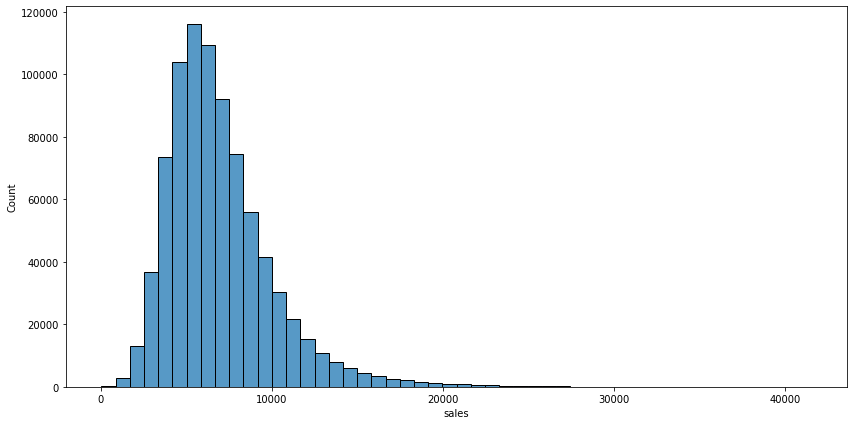

In [27]:
plt.figure(figsize=(14,7))
sns.histplot(df4['sales'], kde=False, bins=50);

### 4.1.2 - Numerical variable

In [28]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

/tmp/ipykernel_4567/3699462638.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax=ax, bins=50);


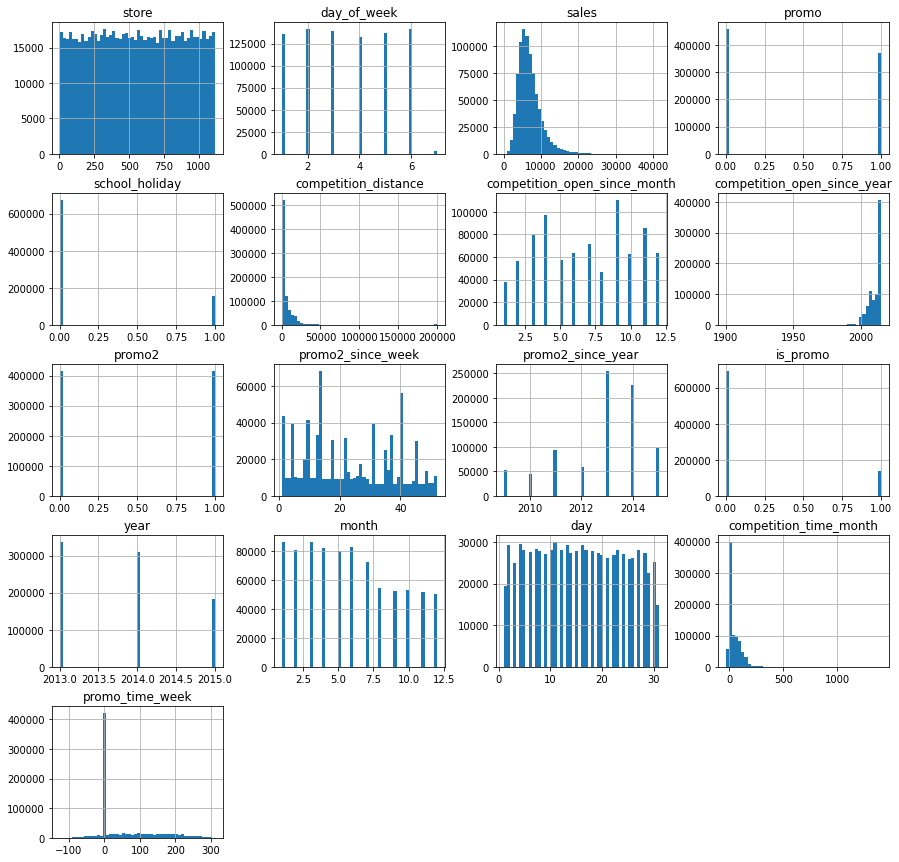

In [29]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50);
#num_attributes.hist(bins=25);

### 4.1.3 - Categorical variable

In [30]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

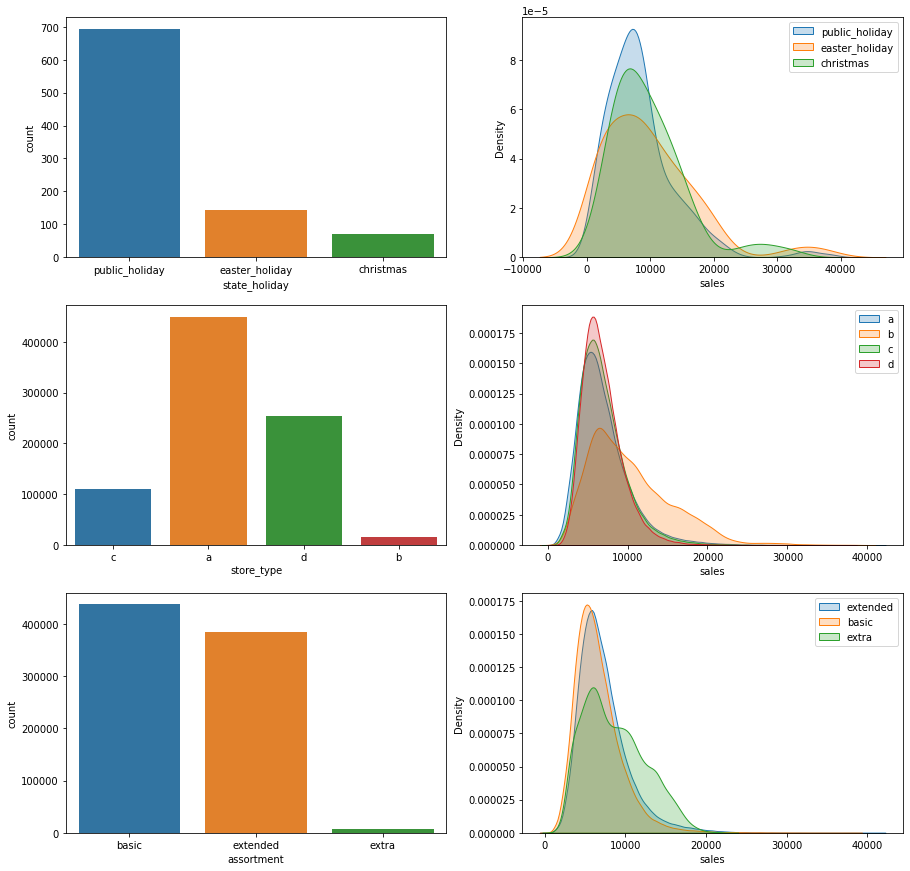

In [31]:
# state_holiday
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday'], x='sales', label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday'], x='sales', label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas'], x='sales', label='christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3,2,4)
sns.kdeplot(data=df4[df4['store_type'] == 'a'], x='sales', label='a', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'b'], x='sales', label='b', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'c'], x='sales', label='c', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'd'], x='sales', label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3,2,6)
sns.kdeplot(data=df4[df4['assortment'] == 'extended'], x='sales', label='extended', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'basic'], x='sales', label='basic', shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'extra'], x='sales', label='extra', shade=True)
plt.legend();

## 4.2 - Bivariate analysis

**H1.** Stores with larger assortments should sell more.

**FALSE** Stores with larger assortment sell LESS.

<AxesSubplot:xlabel='year_week'>

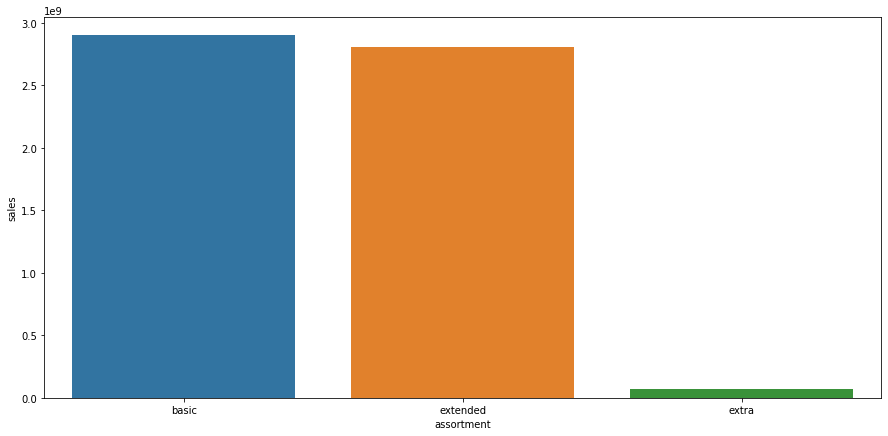

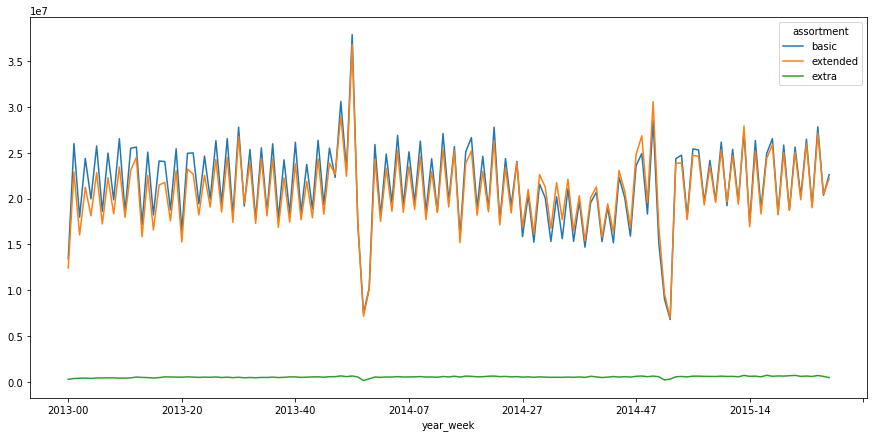

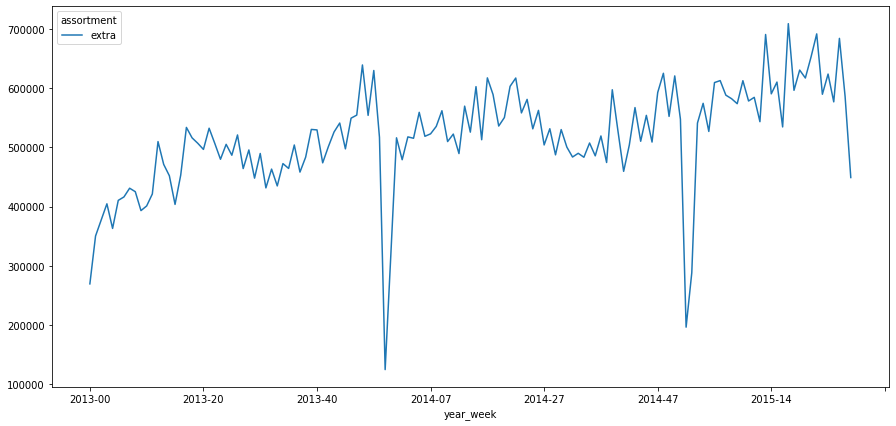

In [32]:
plt.figure(figsize=(15,7))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15,7))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15,7))

**H2.** Stores with closer competitors should sell less.

**FALSE** Store with closer competitors sell MORE.

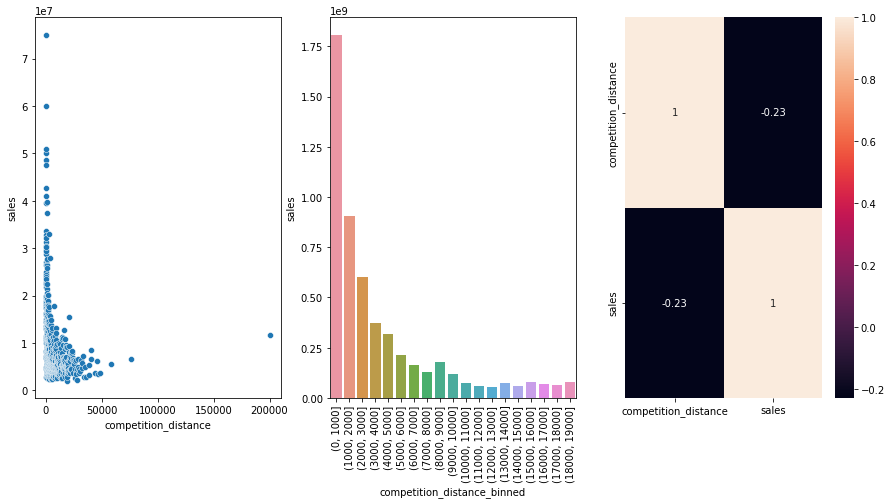

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'), annot=True)

**H3.** Stores with longer competitors should sell more.

**FALSE** Stores with longer competitors sell LESS after a period.

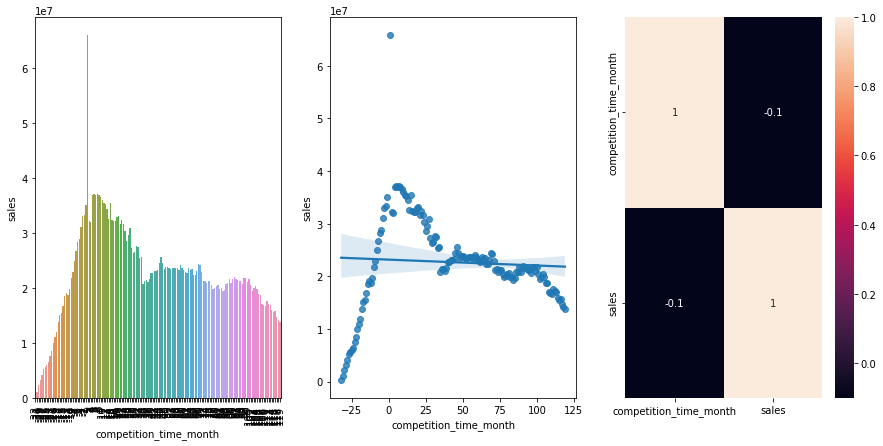

In [34]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

**H4.** Stores with longer active promotions should sell more.

**FALSE** Stores with longer active promotions sell LESS after a period.

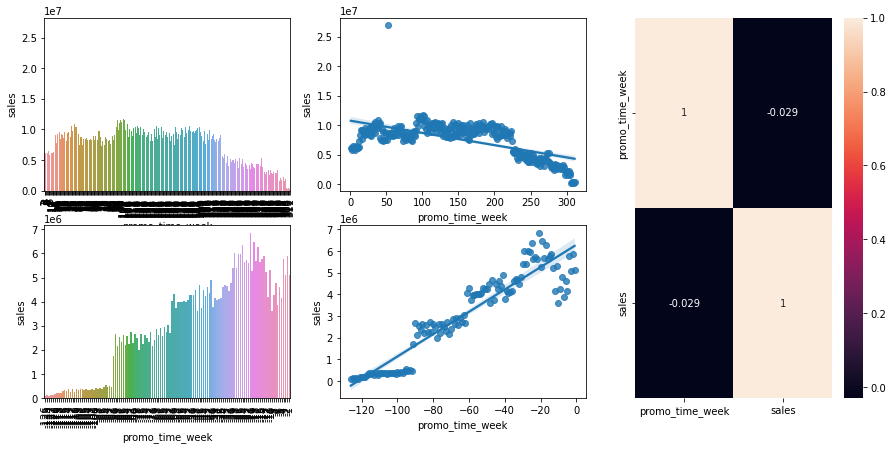

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(15,7))
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # only longer promo
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # only regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

<s> **H5.** Stores with more days of promotion should sell more. <s>

**H6.** Stores with more consecutive promotions should sell more.

**FALSE** Stores with more consecutive promotions sell LESS.

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1458620310
1,0,1,1267204512
2,1,0,1605214763
3,1,1,1448760600


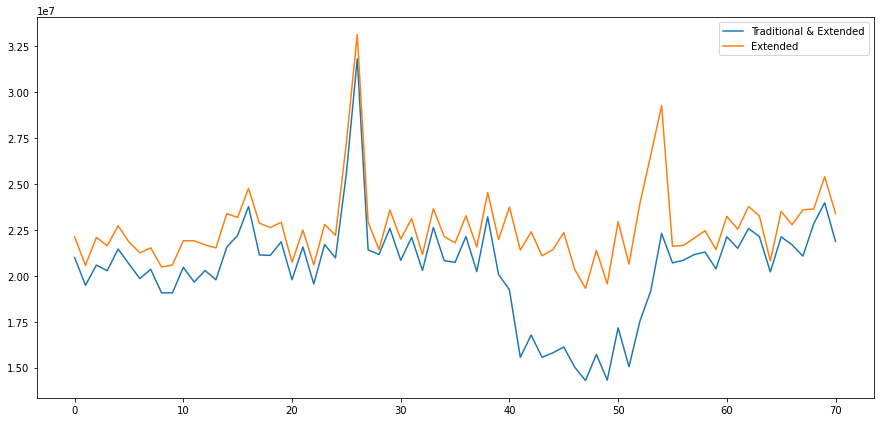

In [47]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,7))

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Traditional & Extended', 'Extended']);

**H7.** Stores open during the Christmas holiday should sell more.

**FALSE** Stores open during the Christmas holiday sell LESS.

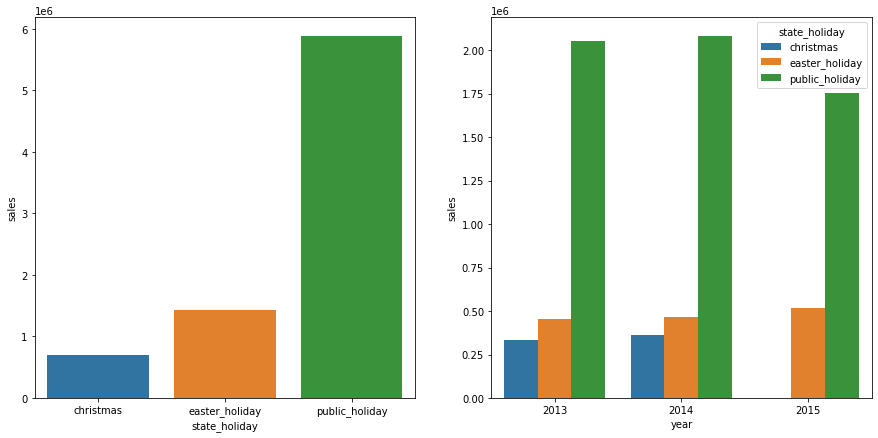

In [51]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

**H8.** Stores should sell more over the years.

**FALSE** Stores sell LESS over the years.

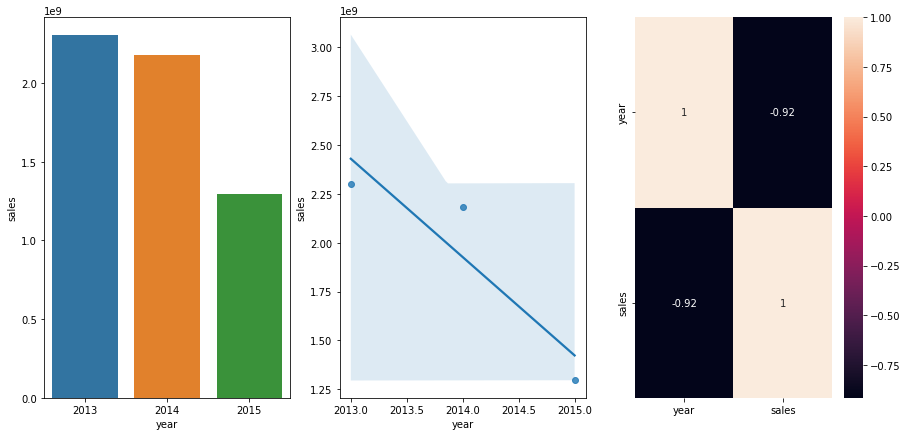

In [53]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H9.** Stores should sell more in the second half of the year.

**FALSE** Stores sell LESS in the second half of the year.

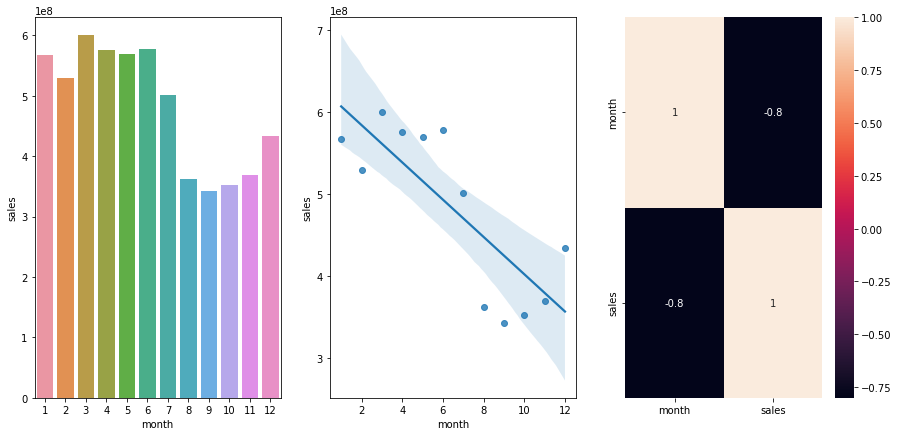

In [54]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H10.** Stores should sell more after the 10th of each month.

**TRUE** Stores sell MORE after the 10th of each month.

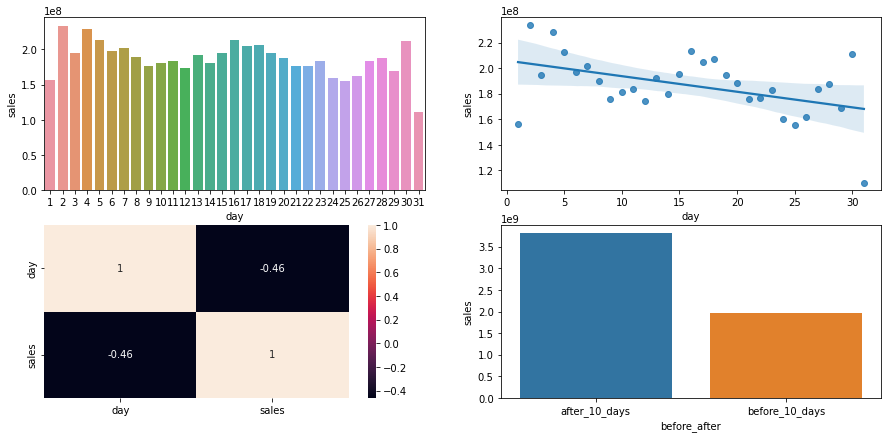

In [57]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

**H11.** Stores should sell less on weekends.

**TRUE** Stores sell LESS on weekends.

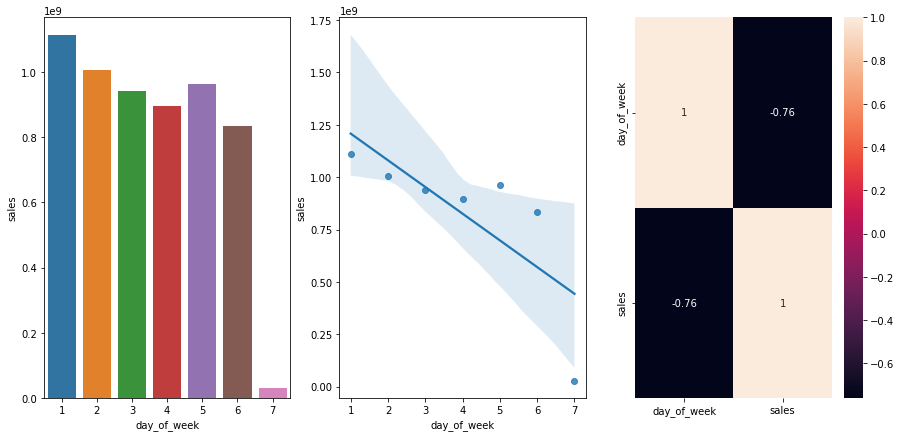

In [59]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**H12.** Stores should sell less during school holidays.

**TRUE** Stores sell LESS during school holidays.

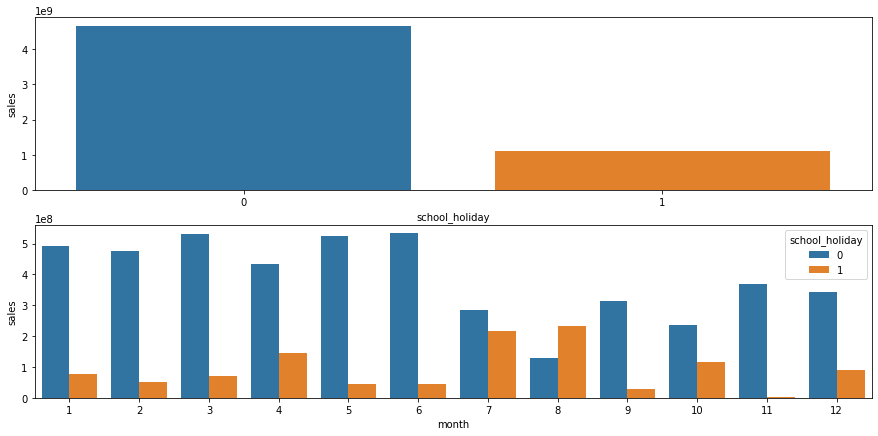

In [62]:
plt.figure(figsize=(15,7))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.3 - Multivariate analysis

### 4.3.1 - Numerical attributes

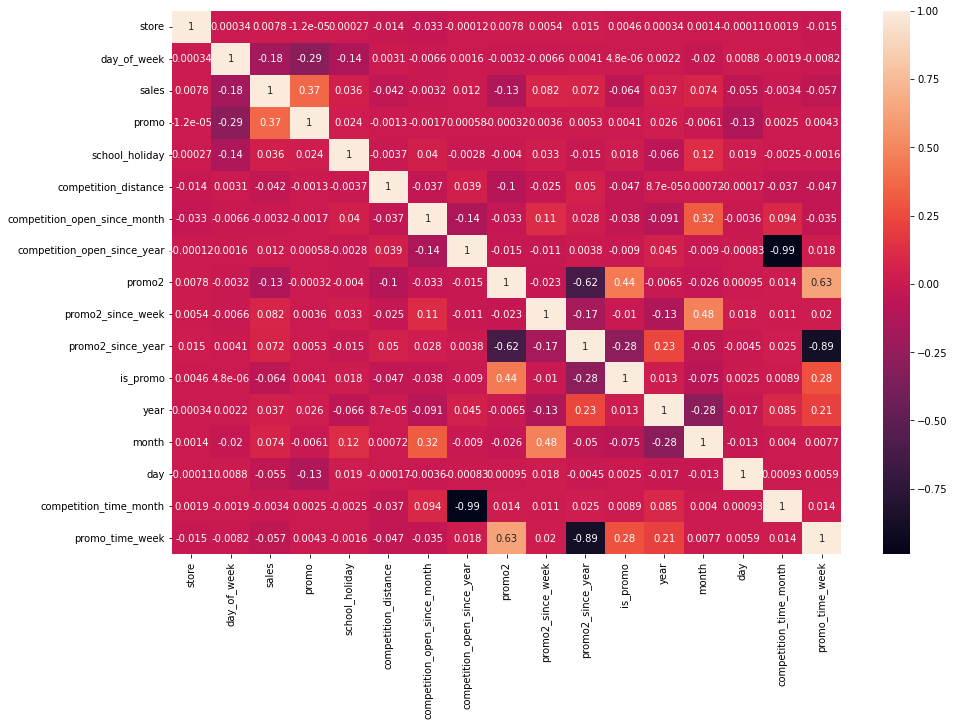

In [66]:
plt.figure(figsize=(15,10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 - Categorical attributes

<AxesSubplot:>

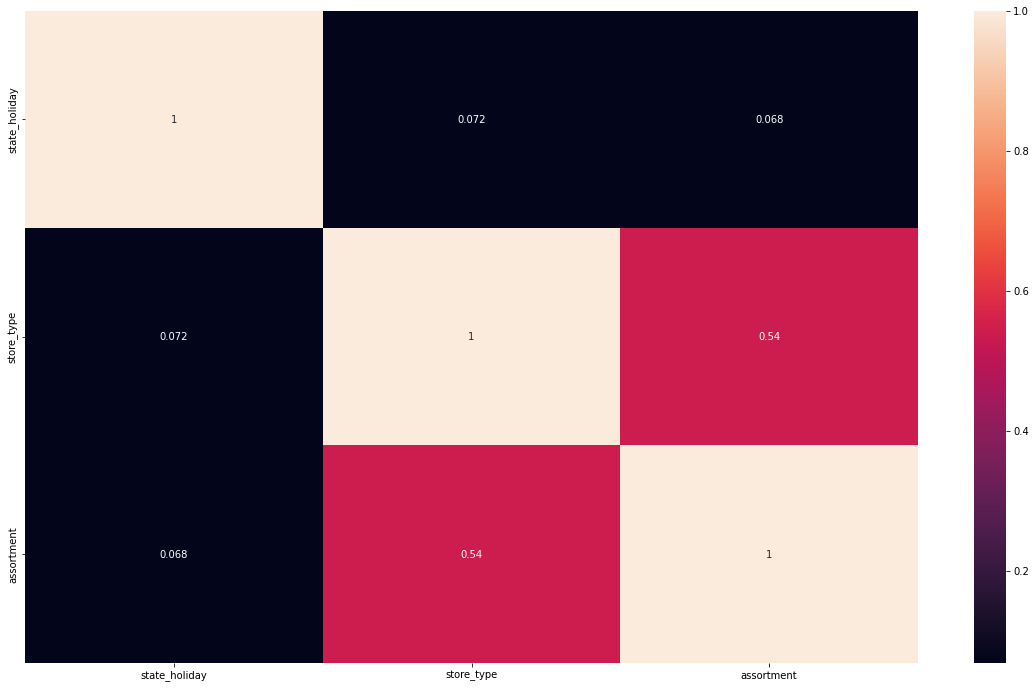

In [75]:
cat_attributes_list = cat_attributes.drop(['week_of_year', 'year_week'], axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list


# plot
plt.figure(figsize=(20,12))
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)